## Databehandling BIRD
Først loades alle modulerne + filer

In [345]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
from scipy.interpolate import make_interp_spline, BSpline

#Importér datafiler
magdata = np.genfromtxt("mag_fil.csv",delimiter=",",names=True,dtype=None,encoding=None)
imutidsdata = open("IMUtid.txt","r").read().splitlines()
imudata = np.genfromtxt("State.csv",delimiter=",",names=True,dtype=None,encoding=None)
yawdata = np.genfromtxt("yaw_3_runs.csv",delimiter=";",names=True,dtype=None,encoding=None)
imuSensor = np.genfromtxt("RawSensors.csv",delimiter=",",names=True,dtype=None,encoding=None) #meget upræcis!!

Konvertering af tid

In [346]:
#konvertér timestamp til sekunder
def convert_time(time_stamp):
    time = time_stamp.split(" ")[1].split(":")
    seconds = int(time[0])*60*60+int(time[1])*60+float(time[2])
    return(seconds)

starttid = convert_time(imutidsdata[0]) #startid for IMU data

#timestamps for hhv magnetometer, kamera, IMU
mag_time = [convert_time(magdata[i][0])-starttid for i in range(len(magdata))]
billede_time = [convert_time(yawdata[i][0])-starttid for i in range(len(yawdata))]
imu_tid = [-0.2+i*0.10 for i in range(len(imudata))]

#sammenlign billedetid med sensortid
def sammenlign_tid(billede_tid,sensor_tid):
    sensor_index = []
    j = 0
    for i in billede_tid:
        while sensor_tid[j] < i:
            j += 1
        if sensor_tid[j] >= i:
            sensor_index.append(j)
            pass
    return sensor_index

#returnerer liste med index i sensorlisten for tilsvarende billede tid 
mag_index = sammenlign_tid(billede_time,mag_time)
imu_index = sammenlign_tid(billede_time,imu_tid)

print(imu_index)


[1651, 1673, 1693, 1714, 1749, 1787, 1825, 1861, 1881, 1902, 1922, 1942, 1963, 1983, 2020, 2056, 3168, 3189, 3209, 3230, 3250, 3307, 3341, 3377, 3413, 3449, 3470, 3490, 3510, 3531, 3551, 4988, 5022, 5057, 5077, 5097, 5118, 5138, 5158, 5178, 5198, 5218, 5238]


In [347]:
start = imu_index[0] #index for første billede
slut = imu_index[-1] #index for sidste billede
start = 1649 #index for første billede
slut = 2054 #index for sidste billede

#magnetometer_vector = [[magdata[i][7],magdata[i][8]*-1,magdata[i][9]*-1] for i in mag_index] #Fluxgate 3D magnetometer data *-1
imuMagx = [i[9]/10 for i in imuSensor] #IMU magnetometer data
imuMagy = [-i[10]/10 for i in imuSensor]
imuMagz = [-i[11]/10 for i in imuSensor] #IMU magnetometer data
roll =  [i[43]*np.pi/180 for i in imudata] #roll fra IMU
pitch = [i[44]*np.pi/180 for i in imudata] #pitch fra IMU
yaw = [float(yawdata[i][1]) for i in range(len(yawdata))] #pitch fra billede
yaw1 = []
k = 0
for i in yaw:
    if i > -180:
        yaw1.append((i-k*360)/180*np.pi)
    elif i == -180:
        yaw1.append((i-k*360)/180*np.pi)
        k = 1
print(yaw1)

#fluxgate data defineres
x = [i[7] for i in magdata]
y = [i[8] for i in magdata]
z = [i[9] for i in magdata]

#fluxgate data interpoleres til at passe til IMU-data med samme sampling-rate på 10Hz
x_interp = np.interp(imu_tid,mag_time,x)
y_interp = np.interp(imu_tid,mag_time,y)
z_interp = np.interp(imu_tid,mag_time,z)

#Yaw data bliver "glattet ud" og tilpasses samplerate på 10Hz
spl = make_interp_spline(billede_time,yaw1, k=3)
yaw_interp = spl(imu_tid[start:slut])

mean_pitch = round(np.mean(pitch[100:300]),3)
mean_roll = round(np.mean(roll[100:300]),3)

maxx = max(x_interp[start:slut])
maxy = max(y_interp[start:slut])
minx = min(x_interp[start:slut])
miny = min(y_interp[start:slut])

offsetx = maxx+minx
offsety = maxy+miny

print(offsetx)
print(offsety)



[-0.5585053606381855, -0.3839724354387525, -0.3665191429188092, -0.7853981633974483, -0.3141592653589793, -0.3665191429188092, -0.3141592653589793, -0.45378560551852565, -0.22689280275926282, -0.47123889803846897, -0.5061454830783556, -0.3141592653589793, -0.3141592653589793, -0.40142572795869574, -0.3490658503988659, -0.6108652381980153, -0.47123889803846897, -0.3490658503988659, -0.3490658503988659, -0.296705972839036, -0.45378560551852565, -0.3839724354387525, -0.3839724354387525, -0.22689280275926282, -0.33161255787892263, -0.33161255787892263, -0.33161255787892263, -0.3839724354387525, -0.3665191429188092, -0.3665191429188092, -0.3490658503988659, -0.5061454830783556, -0.13962634015954636, -0.45378560551852565, -0.33161255787892263, -0.47123889803846897, -0.41887902047863906, -0.3665191429188092, -0.4886921905584123, -0.33161255787892263, -0.3141592653589793, -0.3490658503988659, -0.41887902047863906]
-16.5035757713084
42.45487675502797


Her defineres rotationsmatricen samt undregninge af vinklen

In [348]:
#Rotationsmatrix
def rotate(a,b,c,x):
    R = np.array([[np.cos(a)*np.cos(b),np.cos(a)*np.sin(b)*np.sin(c)-np.sin(a)*np.cos(c),np.cos(a)*np.sin(b)*np.cos(c)+np.sin(a)*np.sin(c)],
    [np.sin(a)*np.cos(b),np.sin(a)*np.sin(b)*np.sin(c)+np.cos(a)*np.cos(c),np.sin(a)*np.sin(b)*np.cos(c)-np.cos(a)*np.sin(c)],
    [-np.sin(b),np.cos(b)*np.sin(c),np.cos(b)*np.cos(c)]])

    M = R@[x[0],-x[1],-x[2]]
    return(M)

def extrinsic_rotation(a,b,c,x):
    R = np.array([[np.cos(b)*np.cos(a),np.sin(c)*np.sin(b)*np.cos(a)-np.cos(c)*np.sin(a),np.cos(c)*np.sin(b)*np.cos(a)+np.sin(c)*np.sin(a)],
    [np.cos(b)*np.sin(a),np.sin(c)*np.sin(b)*np.sin(a)-np.cos(c)*np.cos(a),np.cos(c)*np.sin(b)*np.sin(a)-np.sin(c)*np.cos(a)],
    [-np.sin(b),np.sin(c)*np.cos(b),np.cos(c)*np.cos(b)]])

    M = R@x
    return(M)

def rotate_pitch_roll(yaw,pitch,roll,x):
    #vektor = np.array([[x[0]],[x[1]],[x[2]]])
    #R = np.array([[1,0,0],[0,np.cos(roll),-np.sin(roll)],[0,np.sin(roll),np.cos(roll)]])
    #P = np.array([[np.cos(pitch),0,np.sin(pitch)],[0,1,0],[-np.sin(pitch),0,np.cos(pitch)]])
    #Y = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])
    
    #return(np.transpose(Y@P@R)@x)

    cx = x[0]*np.cos(pitch)+x[1]*np.sin(roll)*np.sin(pitch)+x[2]*np.cos(roll)*np.sin(pitch)
    cy = x[1]*np.cos(roll)-x[2]*np.sin(roll)
    vinkel = 180/np.pi *np.arctan2(-cy,cx)

    return cx,cy,vinkel

#Beregning af vinkel mellem vektor og x-aksen (parrallel med landingsbane)
def vinkel(vektor):
    return np.arctan(vektor[1]/vektor[0])*180/np.pi

In [349]:
rotate_interp_ex = []
kurs_ex = []
for i in range(len(x_interp[start:slut])):
    rotated_vector = rotate(yaw_interp[i],pitch[start+i]-mean_pitch,roll[start+i]-mean_roll,[x_interp[start+i],y_interp[start+i],z_interp[start+i]])
    rotate_interp_ex.append(rotated_vector)
    kurs_ex.append(np.arctan2(-rotated_vector[1]+2.5,rotated_vector[0]-1)*180/np.pi)

x_rotate_interp_ex = [i[0] for i in rotate_interp_ex]
y_rotate_interp_ex = [i[1] for i in rotate_interp_ex]
z_rotate_interp_ex = [i[2] for i in rotate_interp_ex]

minx = min(x_rotate_interp_ex)
maxx = max(x_rotate_interp_ex)
offsetx = minx+maxx
print(minx,maxx,offsetx )
miny = min(y_rotate_interp_ex)
maxy = max(y_rotate_interp_ex)
offsety = miny+maxy
print(miny,maxy, offsety)


# rotate_interp_in = []
# kurs_in = []
# for i in range(len(x_interp[start:slut])):
#     cx,cy,v = rotate_pitch_roll(0,pitch[start+i],roll[start+i],[x_interp[start+i],y_interp[start+i],z_interp[start+i]])
#     rotate_interp_in.append([cx,cy])
#     kurs_in.append(v)

# x_rotate_interp_in = [i[0] for i in rotate_interp_in]
# y_rotate_interp_in = [i[1] for i in rotate_interp_in]
# #z_rotate_interp_in = [i[2] for i in rotate_interp_in]




-31.20899760597641 7.560545480227074 -23.648452125749337
-34.79451647253511 -1.479447528211655 -36.273964000746766


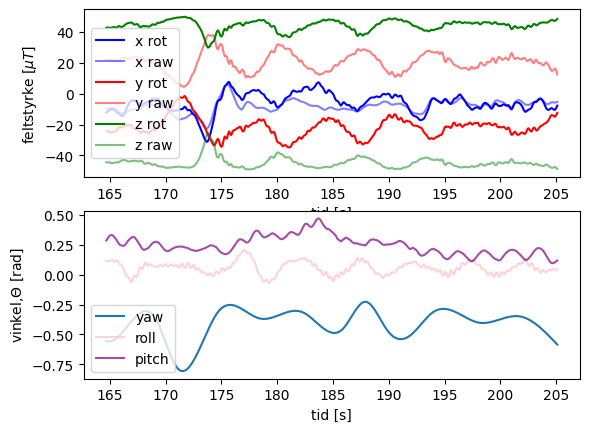

In [350]:
def plot_rotated():
    plt.subplot(211)
    plt.plot(imu_tid[start:slut],x_rotate_interp_ex,color="blue")
    plt.plot(imu_tid[start:slut],x_interp[start:slut],color="blue",alpha=0.5)
    plt.plot(imu_tid[start:slut],y_rotate_interp_ex,color="red")
    plt.plot(imu_tid[start:slut],y_interp[start:slut],color="red",alpha=0.5)
    plt.plot(imu_tid[start:slut],z_rotate_interp_ex,color="green")
    plt.plot(imu_tid[start:slut],z_interp[start:slut],color="green",alpha=0.5)
    #plt.vlines(x = billede_time, ymin = -55, ymax = 28,colors = "black",alpha=0.5,linestyles="dashed")
    plt.legend(["x rot","x raw","y rot","y raw","z rot","z raw"])
    plt.xlabel("tid [s]")
    plt.ylabel("feltstyrke [$\mu T]$")

    plt.subplot(212)
    lines = np.arange(60,160,1)
    plt.plot(imu_tid[start:slut],yaw_interp)
    plt.plot(imu_tid[start:slut],roll[start:slut]-mean_roll,color="pink",alpha=0.7)
    plt.plot(imu_tid[start:slut],pitch[start:slut]-mean_pitch,color="purple",alpha=0.7)
    #plt.vlines(lines,-2,2,color="black",alpha=0.5)
    #plt.scatter(billede_time,yaw,color="black")
    #plt.vlines(x = billede_time, ymin = -0.3, ymax = 0.3,colors = "black",alpha=0.5,linestyles="dashed")
    plt.legend(["yaw","roll","pitch"])
    plt.xlabel("tid [s]")
    plt.ylabel("vinkel,$\Theta$ [rad]")
    plt.show()

plot_rotated()

1649
2054


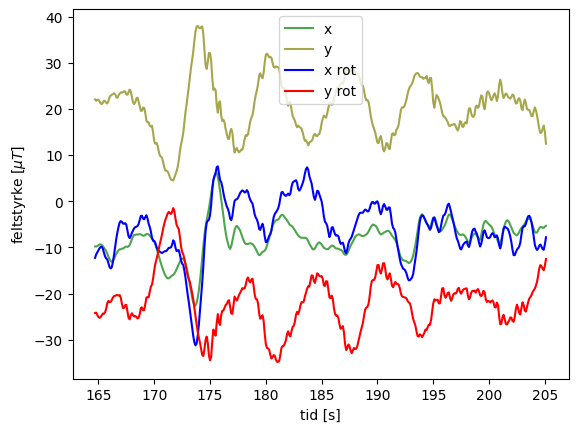

In [351]:
print(start)
print(slut)

plt.plot(imu_tid[start:slut],x_interp[start:slut],color="green",alpha=0.7)
plt.plot(imu_tid[start:slut],y_interp[start:slut],color="olive",alpha=0.7)
plt.plot(imu_tid[start:slut],x_rotate_interp_ex,color="blue")
plt.plot(imu_tid[start:slut],y_rotate_interp_ex,color="red")
#plt.plot(imu_tid[start:slut],z_interp[start:slut],color="green",alpha=0.7)
#plt.plot(imu_tid[start:slut],imuMagx[start:slut],color="blue")
#plt.plot(imu_tid[start:slut],imuMagy[start:slut],color="red")
#plt.plot(imu_tid[start:slut],imuMagz[start:slut],color="green")
#plt.vlines(x = billede_time, ymin = -20, ymax = 20,colors = "black",alpha=0.5,linestyles="dashed")
plt.legend(["x","y","x rot","y rot"])
plt.xlabel("tid [s]")
plt.ylabel("feltstyrke [$\mu T]$")

plt.show()


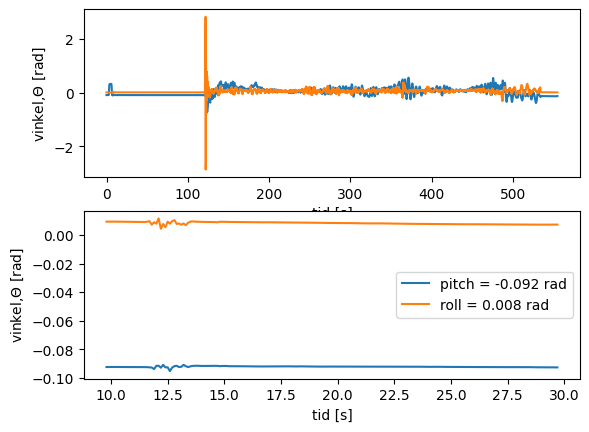

In [352]:
def plot_pitch_roll():
    plt.subplot(211)
    plt.plot(imu_tid,pitch)
    plt.plot(imu_tid,roll)
    plt.xlabel("tid [s]")
    plt.ylabel("vinkel,$\Theta$ [rad]")
    plt.subplot(212)
    plt.plot(imu_tid[100:300],pitch[100:300])
    plt.plot(imu_tid[100:300],roll[100:300])
    plt.xlabel("tid [s]")
    plt.ylabel("vinkel,$\Theta$ [rad]")
    plt.legend(["pitch = {} rad".format(mean_pitch),"roll = {} rad".format(mean_roll)])
    plt.show()

plot_pitch_roll() 

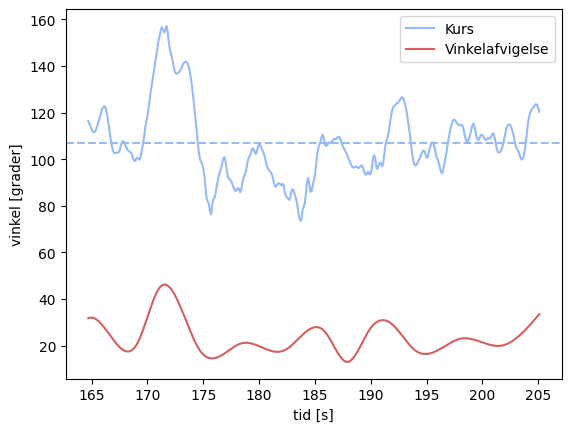

In [353]:
Yaw = []
for i in yaw:
    Yaw.append(-i)

spl1 = make_interp_spline(billede_time,Yaw, k=3)
yaw_interp1 = spl1(imu_tid[start:slut])



def plot_kurs():
    ex_mean = int(round(np.mean(kurs_ex),0))
    plt.plot(imu_tid[start:slut],kurs_ex,color="#95baf7")
    plt.plot(imu_tid[start:slut],yaw_interp1,"#d45f5f")
    plt.axhline(y = ex_mean, color = '#95baf7', linestyle = 'dashed')
    #plt.text(200,93,"gns = 107")
    #plt.vlines(billede_time,-50,50)
    plt.xlabel("tid [s]")
    plt.ylabel("vinkel [grader]")
    plt.legend(["Kurs","Vinkelafvigelse"])
    plt.show()

plot_kurs()

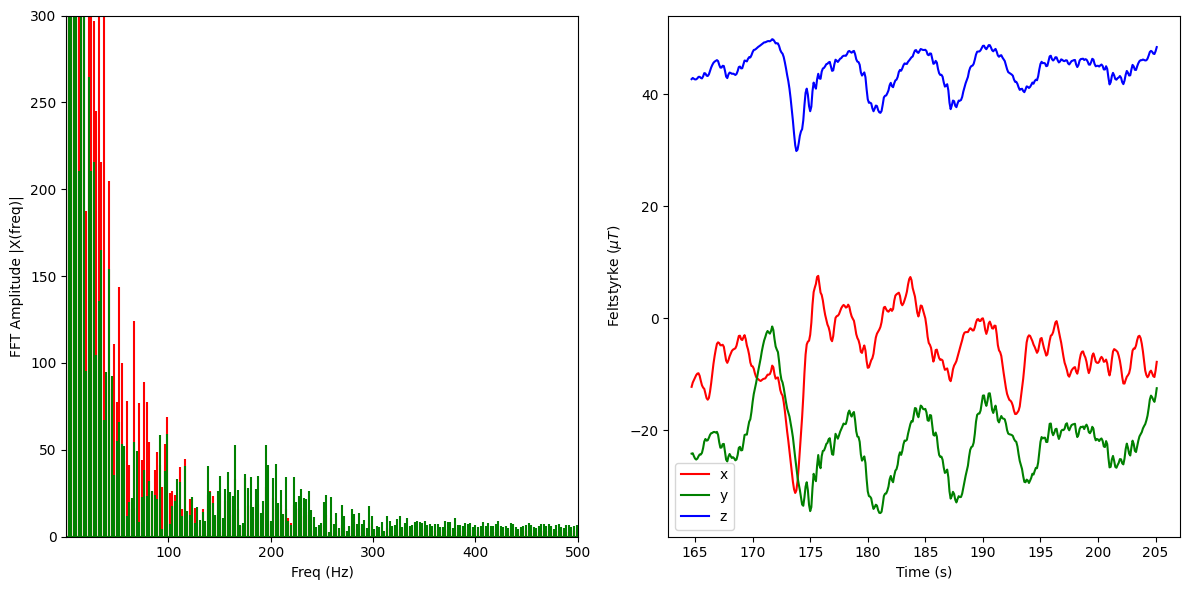

In [354]:
def FFT():
    X = fft(x_rotate_interp_ex)
    Y = fft(y_rotate_interp_ex)
    Z = fft(z_rotate_interp_ex)
    t = imu_tid[start:slut]
    N = len(X)
    n = np.arange(N)
    T = N/1000
    freq = n/T 

    plt.figure(figsize = (12, 6))
    plt.subplot(121)

    plt.stem(freq, np.abs(X), 'r', \
            markerfmt=" ", basefmt="-r")
    plt.stem(freq, np.abs(Y), 'g', \
            markerfmt=" ", basefmt="-g")
    #plt.stem(freq, np.abs(X), 'b', \
            #markerfmt=" ", basefmt="-b")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.xlim(0.1, 500)
    plt.ylim(0,300)

    plt.subplot(122)
    plt.plot(t, x_rotate_interp_ex, 'r')
    plt.plot(t,y_rotate_interp_ex,"g")
    plt.plot(t,z_rotate_interp_ex,"b")
    plt.legend(["x","y","z"])
    plt.xlabel('Time (s)')
    plt.ylabel('Feltstyrke ('r'$\mu T)$')
    plt.tight_layout()
    plt.show()

FFT()